## Setting

In [ ]:
!pip install xgboost lightgbm catboost -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
import pickle
import pandas as pd
import numpy as np

In [ ]:
root = "/content/drive/MyDrive/Machine Learning/"
sys.path.append(root)
sys.path.append(os.getcwd())

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from close.train_tuning import Model
from close.evaluation import show_confusion_matrix, per_class_accuracy, overall_metrics, top_k_accuracy, confidence_analysis


In [ ]:
is_binary = False
use_original_data = False
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

## Loading Data

In [ ]:
# Load the pickle file
print("Loading datafile...")
with open(f"{root}data/preprocess_data_33/close_train_33.pkl", "rb") as f:
    train = pickle.load(f)
    X_train = pd.DataFrame(train["X"])
    X_train.columns = train["feature_names"]
    y_train = train["y"]

with open(f"{root}data/preprocess_data_33/close_val_33.pkl", "rb") as f:
    val = pickle.load(f)
    X_val = pd.DataFrame(val["X"])
    X_val.columns = val["feature_names"]
    y_val = val["y"]

if use_original_data:
  X_train = train['scaler'].inverse_transform(train['X'])
  X_train = pd.DataFrame(X_train)
  X_train.columns = train['feature_names']

  X_val = val['scaler'].inverse_transform(val['X'])
  X_val = pd.DataFrame(X_val)
  X_val.columns = val['feature_names']

print("Loading complete.")
print("Training data size:\t", len(X_train))
print("Validation data size:\t", len(X_val))

Loading datafile...
Loading complete.
Training data size:	 13300
Validation data size:	 2850


## Model

SVM

In [ ]:
model_code = "svm"

svm_param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["rbf", "linear"],
    "gamma": ["scale"]
}

### Base Model Training

In [ ]:
mdl = Model(is_binary=is_binary, code=model_code)

mdl.create_model(model_code, kernel="linear", C=1.0)
mdl.fit(X_train, y_train)

fi_sorted = mdl.get_feature_importances()
ranked_names = list(fi_sorted.keys())

In [ ]:
k_list = [10, 20, 26, 33]

def make_feature_combinations(ranked_names, k_list):
    combos = []
    for k in k_list:
        real_k = min(k, len(ranked_names))
        combos.append({
            "k": real_k,
            "features": ranked_names[:real_k]
        })
    return combos

feature_combinations = make_feature_combinations(ranked_names, k_list)

In [ ]:
results = []
best_overall_model = None
best_overall_acc = -1
best_overall_features = []

for comb in feature_combinations:
    k = comb["k"]
    feat_names = comb["features"]

    print(f"\nBaseline SVM subset: k={k}")
    print("Features:", feat_names)

    X_train_sub = X_train[feat_names]
    X_val_sub   = X_val[feat_names]

    model = Model(is_binary=is_binary)
    model.create_model(model_code)
    print("Using baseline hparams:", model.hparams)

    model.fit(X_train_sub, y_train)

    val_acc = model.score(X_val_sub, y_val)
    print(f"[k={k}] Val Acc = {val_acc:.4f}")

    cv_scores = model.k_fold_cv(X_train_sub, y_train, k=5)

    results.append({
        "k": k,
        "features": feat_names,
        "val_acc": val_acc,
        "cv_mean": np.mean(cv_scores),
        "cv_scores": cv_scores.tolist(),
    })

results_df = pd.DataFrame(results).sort_values(by="val_acc", ascending=False)
print("\n=== Summary (baseline hparams, feature subsets) ===")
print(results_df)


Baseline SVM subset: k=10
Features: ['burst_max_first30', 'burst_ratio_in', 'burst_std', 'burst_std_first30', 'burst_mean', 'switch_count_first30', 'burst_count_first30', 'burst_max', 'burst_ratio_in_first30', 'burst_mean_first30']
Using baseline hparams: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}
[k=10] Val Acc = 0.5323
5-fold Cross Validation Scores:	[0.51842105 0.51390977 0.51466165 0.50864662 0.50300752]
5-fold Cross Validation Average Score:	0.5117293233082707

Baseline SVM subset: k=20
Features: ['burst_max_first30', 'burst_ratio_in', 'burst_std', 'burst_std_first30', 'burst_mean', 'switch_count_first30', 'burst_count_first30', 'burst_max', 'burst_ratio_in_first30', 'burst_mean_first30', 'ratio_out', 'frac_in', 'num_out', 'q75_iat_first30', 'mean_iat', 'std_iat', 'duration', 'mean_iat_first30', 'duration_first30', 'num_in']
Using baseline hparams: {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}
[k=20] Val Acc = 0.6323
5-fold Cross Validation Scores:	[0.62180451 0.60526316 0.621

### Feature Evaluation

In [ ]:
mdl.get_feature_importances()

{'burst_max_first30': 0.987405233655159,
 'burst_ratio_in': -0.5923893914579978,
 'burst_std': -0.44061791863365507,
 'burst_std_first30': 0.4370173889669833,
 'burst_mean': -0.3795147105762119,
 'switch_count_first30': -0.3168179420722663,
 'burst_count_first30': -0.3168179420722663,
 'burst_max': 0.22884861626912828,
 'burst_ratio_in_first30': 0.2278280835373335,
 'burst_mean_first30': 0.19169774037577292,
 'ratio_out': 0.14395053400811064,
 'frac_in': -0.14395053400811064,
 'num_out': 0.12183083679160922,
 'q75_iat_first30': -0.11258206853012803,
 'mean_iat': 0.09954257939647615,
 'std_iat': -0.09712762838350221,
 'duration': 0.06829016458656728,
 'mean_iat_first30': 0.0677667599123162,
 'duration_first30': 0.0677667599123162,
 'num_in': -0.06519601347039683,
 'n_packets': -0.04986163459584736,
 'in_first30': -0.03593556852317614,
 'out_first30': 0.03593556852317614,
 'ratio_out_first30': 0.03593556852317614,
 'frac_in_first30': -0.03593556852317614,
 'switch_count': -0.011434366808

### Hyperparameter Tuning

In [ ]:
svm_results = {}

global_best_acc = -1
model_best = None
best_features = None
best_k_val = None

for k in k_list:
    current_comb = [c for c in feature_combinations if c["k"] == k][0]
    feat_names = current_comb["features"]

    print(f"\n{'='*10} GridSearch for k={k} {'='*10}")
    print("Features:", feat_names)

    X_train_sub = X_train[feat_names]
    X_val_sub   = X_val[feat_names]

    model = Model(is_binary=False)
    model.create_model(model_code)

    bst = model.grid_search(X_train_sub, y_train, svm_param_grid, verbose=1)

    best_model  = bst.best_estimator_
    best_params = bst.best_params_
    best_cv     = bst.best_score_
    val_acc     = best_model.score(X_val_sub, y_val)

    print(f"\n=== Result (k={k}) ===")
    print("best_cv_score:", best_cv)
    print("val_acc      :", val_acc)
    print("best_params  :", best_params)

    svm_results[k] = {
        "model": best_model,
        "params": best_params,
        "cv_score": best_cv,
        "val_acc": val_acc
    }

    if val_acc > global_best_acc:
        global_best_acc = val_acc
        model_best = best_model
        best_features = feat_names
        best_k_val = k


========== GridSearch for k=10 ==========
Features: ['burst_max_first30', 'burst_ratio_in', 'burst_std', 'burst_std_first30', 'burst_mean', 'switch_count_first30', 'burst_count_first30', 'burst_max', 'burst_ratio_in_first30', 'burst_mean_first30']
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Model type:	Support Vector Classification Model
Best score:	0.6667669172932331
Best parameters:	{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best estimator:	SVC(C=100, probability=True)

=== Result (k=10) ===
best_cv_score: 0.6667669172932331
val_acc      : 0.6856140350877193
best_params  : {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

========== GridSearch for k=20 ==========
Features: ['burst_max_first30', 'burst_ratio_in', 'burst_std', 'burst_std_first30', 'burst_mean', 'switch_count_first30', 'burst_count_first30', 'burst_max', 'burst_ratio_in_first30', 'burst_mean_first30', 'ratio_out', 'frac_in', 'num_out', 'q75_iat_first30', 'mean_iat', 'std_iat', 'duration', 'mean_iat_firs

### Evaluation

In [ ]:
print(f"Best SVM Model found at k={best_k_val} with Val Acc={global_best_acc:.4f}")

X_val_best = X_val[best_features]
y = y_val

y_pred = model_best.predict(X_val_best)
y_prob = model_best.predict_proba(X_val_best)

n_classes = len(np.unique(y_train))
class_names = [str(i) for i in range(n_classes)]

Best SVM Model found at k=33 with Val Acc=0.8130


1. Confusion Matrix



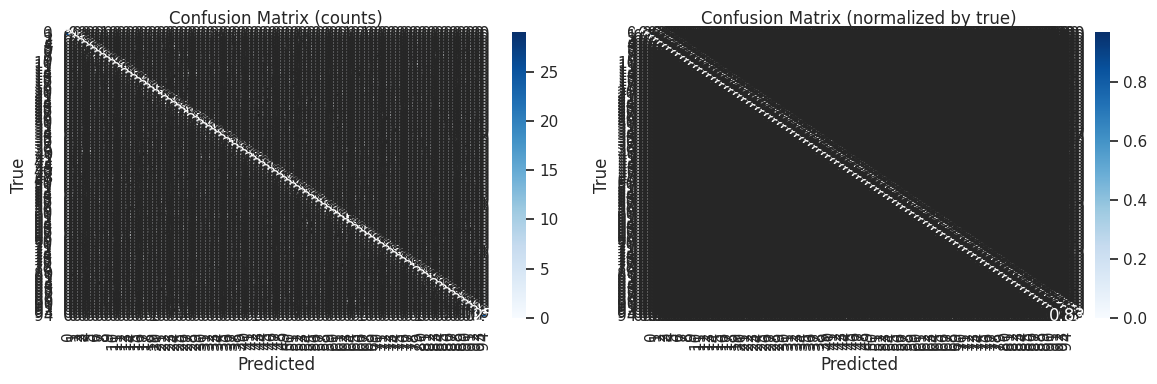

<Figure size 640x480 with 0 Axes>

In [ ]:
cm = show_confusion_matrix(y, y_pred, class_names, model_code)

2. Per-class Accuracy



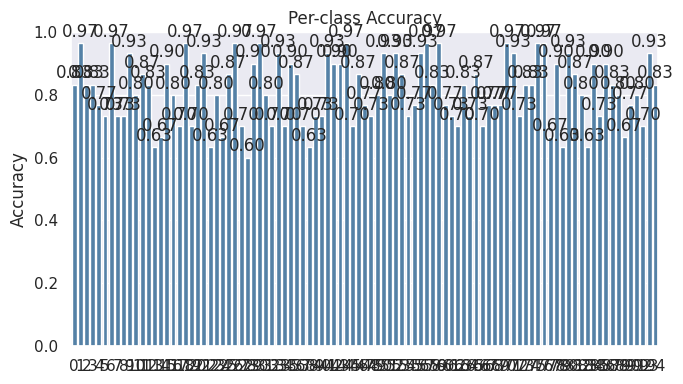

<Figure size 640x480 with 0 Axes>

In [ ]:
per_class_accuracy(cm, class_names, model_code)

In [ ]:
overall_metrics(y, y_pred, y_prob, n_classes)

3. Overall Metrics

- Accuracy: 0.8130
- Macro F1: 0.8126 (macro P=0.8184, macro R=0.8130)
- Weighted F1: 0.8126 (weighted P=0.8184, weighted R=0.8130)
- Log Loss: 0.9937


In [ ]:
top_k_accuracy(y, y_prob, n_classes)

4. Top k Accuracy

- Top-1 accuracy: 0.8077
- Top-3 accuracy: 0.9196
- Top-5 accuracy: 0.9449


5. Confidence Analysis



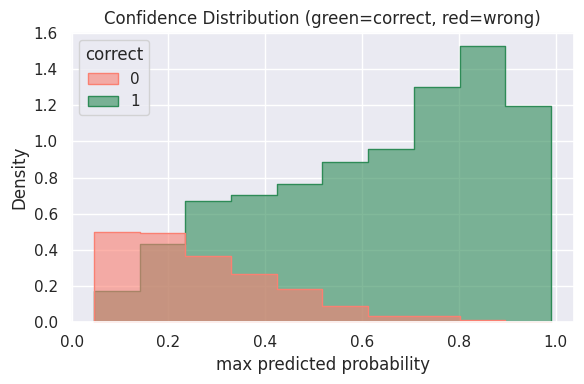

<Figure size 640x480 with 0 Axes>

In [ ]:
confidence_analysis(y, y_pred, y_prob, model_code)

### Save Model

In [ ]:
print(f"Saving best model (k={best_k_val})...")
mdl.save_model(model=model_best, file_name=f"best_lr_k{best_k_val}_{global_best_acc:.4f}")

Saving best model (k=33)...
